In [1]:
import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed

from utils import *

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


%matplotlib inline 

In [2]:
car_images, not_car_images = load_car_not_car_images()

var/non-vehicles/Extras (5068, 64, 64, 3) 5068
var/non-vehicles/GTI (3900, 64, 64, 3) 3900
var/vehicles/GTI_Far (834, 64, 64, 3) 834
var/vehicles/GTI_Left (909, 64, 64, 3) 909
var/vehicles/GTI_MiddleClose (419, 64, 64, 3) 419
var/vehicles/GTI_Right (664, 64, 64, 3) 664
var/vehicles/KITTI_extracted (5966, 64, 64, 3) 5966


In [3]:
car_features = extract_color_features(car_images, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_color_features(not_car_images, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

100%|██████████| 8968/8968 [00:18<00:00, 491.44it/s]


In [4]:
# sample_size = 10000
# cars = car_images[0:sample_size]
# notcars = not_car_images[0:sample_size]

cars = car_images
notcars = not_car_images

colorspace = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_scaler = RobustScaler().fit(X)
# X_scaler = MinMaxScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:18<00:00, 483.34it/s]


40.13 Seconds to extract HOG features...
Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3456


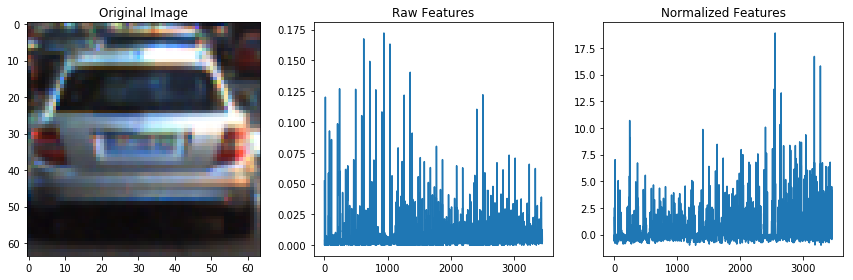

In [5]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(car_images[car_ind], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.59 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
0.00372 Seconds to predict 10 labels with SVC


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1,max_depth=None, min_samples_split=10, random_state=0)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train ExtraTrees...')
# Check the score of the RandomForest
print('Train Accuracy of  ExtraTrees = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of ExtraTrees = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My ExtraTrees predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with ExtraTrees')

5.2 Seconds to train ExtraTrees...
Train Accuracy of  ExtraTrees =  1.0
Test Accuracy of ExtraTrees =  0.9825
My ExtraTrees predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
0.10732 Seconds to predict 10 labels with ExtraTrees


In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=10, random_state=0)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train RandomForest...')
# Check the score of the RandomForest
print('Train Accuracy of RandomForest = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of RandomForest = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My RandomForest predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RandomForest')

10.93 Seconds to train RandomForest...
Train Accuracy of RandomForest =  0.9999
Test Accuracy of RandomForest =  0.9882
My RandomForest predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
0.10894 Seconds to predict 10 labels with RandomForest
